# BT5153 Reddit post classification - BOW Models

In [1]:
import pandas as pd 
import numpy as np 
from sklearn import decomposition, ensemble
import textblob, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import imblearn
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
tqdm.pandas()

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ananth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ananth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ananth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ananth\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 1. Read the Data

In [3]:
df_train = pd.read_csv('Data Train and Test/reddit_train.csv')
df_train.drop(columns='Unnamed: 0', inplace=True)
print('Shape of train data:',df_train.shape)
df_train.head()

Shape of train data: (1269, 6)


,author,postdate,subreddit,Text,Word_count,Outcome
0,TFDP117,2020-07-03 03:02:00,suicide watch,My family and friends are the only thing keepi...,25,1.0
1,jaleel364,2020-02-14 08:28:00,confession,I’m the guy who puts food in random places in ...,27,0.0
2,mabbers110,2020-03-16 07:47:00,depression,Has anyone here had their life completely turn...,126,0.0
3,AdrianaAura-,2020-08-03 12:44:00,suicide watch,i'm so tired and cold i'm tired\n\nand i just ...,42,1.0
4,vizzy111,2020-03-24 17:05:00,suicide watch,"They said ma days are numbered, but I keep wak...",23,0.0


In [4]:
df_test = pd.read_csv('Data Train and Test/reddit_test.csv')
df_test.drop(columns='Unnamed: 0', inplace=True)
print('Shape of train data:',df_test.shape)
df_test.head()

Shape of train data: (318, 6)


,author,postdate,subreddit,Text,Word_count,Outcome
0,ASOBITAIx4,2020-03-28 03:44:00,confession,My boss said I have a good work ethic when I s...,60,0.0
1,crushedweek,2020-03-27 17:19:00,depression,I feel like I'm not depressed I don't have a r...,134,1.0
2,tylermufc10,2020-02-27 07:50:00,confession,I used to snort sherbert from the corner shop ...,58,0.0
3,BleachtrumpsNaruto,2020-09-02 04:52:00,confession,I caused someone to die because of a seemingly...,201,0.0
4,Nillend,2020-03-30 05:44:00,depression,I often wonder why do I even bother Nothing I ...,24,0.0


In [5]:
#View sample posts
outcome = [0,1,2]

for x in outcome:
    print('Class:',x)
    tmp = df_train.loc[df_train['Outcome']==x]
    tmp.reset_index(inplace=True)
    print(tmp.loc[0:10,'Text'])
    print(20*'-')

Class: 0
0     I’m the guy who puts food in random places in ...
1     Has anyone here had their life completely turn...
2     They said ma days are numbered, but I keep wak...
3     I don’t know how to deal with this on my own w...
4     Fat People who buy supersized orders and then ...
5     2020 2020 is arguably the worst year for the W...
6     It feels like something is out to get me. No m...
7     How much does a hospital stay for suicide watc...
8     Never had a girlfriend I think i am gona die a...
9     I lied to get a job When I was 23 I got a job ...
10    When I was a teenager, I found my mum in a mag...
Name: Text, dtype: object
--------------------
Class: 1
0     My family and friends are the only thing keepi...
1     i'm so tired and cold i'm tired\n\nand i just ...
2     I'm lonely and nobody is there for me I've bee...
3     I want to disappear It's been 5 years of inter...
4     I felt better for a few months; now I'm worse ...
5     Lost I'm writing here because I h

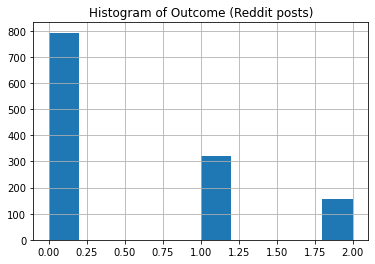

In [6]:
#Distribution of target variable
df_train.Outcome.hist()
plt.title('Histogram of Outcome (Reddit posts)')
plt.show()

## 2. Data Cleaning

In [7]:
def pre_process(text):

    #remove url
    text = re.sub(r"http\S+", "", text)

    #remove special cahracters
    text = re.sub('\W', ' ', text)

    #remove digits
    text = re.sub(r'\d+', '', text)

    #remove _
    text = text.replace('_',' ')

    #remove white spaces
    text = re.sub(r"\s+"," ", text)

    #to lower
    text = text.lower()

    #remove stopwords
    text =' '.join([word for word in text.split() if word not in (stop_words)])

    #lemmitize
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

In [8]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [9]:
#post with emoji
t_str = df_train.loc[13,'Text']
print('original post:\n',t_str)
print(20*'-')
print('Processed post:\n',pre_process(t_str))

original post:
 Never had a girlfriend I think i am gona die a virgin or something :(
Thanks to this corana shit 🙂
--------------------
Processed post:
 never girlfriend think gona die virgin something thanks corana shit


In [10]:
#post with _
t_str = df_train.loc[172,'Text']
print('original post:\n',t_str)
print(20*'-')
print('Processed post:\n',pre_process(t_str))

original post:
 I start arguments everywhere online so someone will talk to me ; _ ; I live alone in the basement of an internet cafe and live on garbage nobody loves me I've never even seen what a smile looks like unless it was on a screen.
--------------------
Processed post:
 start argument everywhere online someone talk live alone basement internet cafe live garbage nobody love never even seen smile look like unless screen


In [11]:
#post with numbers and paragraphs
t_str = df_train.loc[15,'Text']
print('original post:\n',t_str)
print(20*'-')
print('Processed post:\n',pre_process(t_str))

original post:
 When I was a teenager, I found my mum in a magazine As the title says,

When I was a teenager about 13 or 14 i got one of those magazines from one of my friends, you all know what I'm talking about. I took it home and was having a jerk session that night, I was flipping through the pages until I saw it, the face of my mum. I was shocked none of my friends realized that she was in there, and I was shocked that I found it. I never knew she did that kind of thing it was when she was in her early 20's (she had me at 25) I think.

I kept flicking through but I couldn't get the thought of her out of my head so I flipped back and started jerking it and on from there.

I was ashamed straight after I finished but man she looked good.

Sorry for the bad English its my 2nd language.

TLDR: found my mum in a porn magazine and jacked it to her
--------------------
Processed post:
 teenager found mum magazine title say teenager got one magazine one friend know talking took home jerk 

In [12]:
#post with url
t_str = df_train.loc[202,'Text']
print('original post:\n',t_str)
print(20*'-')
print('Processed post:\n',pre_process(t_str))

original post:
 When I was a child my sister was murdered and now I drink everyday to drown the pain. https://www.websleuths.com/forums/threads/az-selenia-moreno-2-dies-at-chandler-day-care-5-nov-2008.78410/

This is the last place I could find information about her story.
--------------------
Processed post:
 child sister murdered drink everyday drown pain last place could find information story


In [13]:
#post with /
t_str = df_train.loc[1004,'Text']
print('original post:\n',t_str)
print(20*'-')
print('Processed post:\n',pre_process(t_str))

original post:
 Mental Health Crisis Services Preparation in COVID-19 New article on the importance of behavioral health crisis services functionality during COVID-19. 

 [https://www.tbdsolutions.com/helping-when-it-matters-most/](https://www.tbdsolutions.com/helping-when-it-matters-most/)
--------------------
Processed post:
 mental health crisis service preparation covid new article importance behavioral health crisis service functionality covid


In [14]:
df_train['Text_processed'] = df_train['Text'].progress_apply(lambda text: pre_process(text))
print('Shape of train data:', df_train.shape)
df_train.head()

100%|████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 4472.20it/s]

Shape of train data: (1269, 7)


,author,postdate,subreddit,Text,Word_count,Outcome,Text_processed
0,TFDP117,2020-07-03 03:02:00,suicide watch,My family and friends are the only thing keepi...,25,1.0,family friend thing keeping suicide reason liv...
1,jaleel364,2020-02-14 08:28:00,confession,I’m the guy who puts food in random places in ...,27,0.0,guy put food random place walmart reason feel ...
2,mabbers110,2020-03-16 07:47:00,depression,Has anyone here had their life completely turn...,126,0.0,anyone life completely turned around currently...
3,AdrianaAura-,2020-08-03 12:44:00,suicide watch,i'm so tired and cold i'm tired\n\nand i just ...,42,1.0,tired cold tired want school life fucking joke...
4,vizzy111,2020-03-24 17:05:00,suicide watch,"They said ma days are numbered, but I keep wak...",23,0.0,said day numbered keep waking think world stil...


In [15]:
df_test['Text_processed'] = df_test['Text'].progress_apply(lambda text: pre_process(text))
print('Shape of train data:', df_test.shape)
df_test.head()

100%|██████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 4684.91it/s]

Shape of train data: (318, 7)


,author,postdate,subreddit,Text,Word_count,Outcome,Text_processed
0,ASOBITAIx4,2020-03-28 03:44:00,confession,My boss said I have a good work ethic when I s...,60,0.0,bos said good work ethic spend half workday pl...
1,crushedweek,2020-03-27 17:19:00,depression,I feel like I'm not depressed I don't have a r...,134,1.0,feel like depressed real good reason deserve d...
2,tylermufc10,2020-02-27 07:50:00,confession,I used to snort sherbert from the corner shop ...,58,0.0,used snort sherbert corner shop innit understa...
3,BleachtrumpsNaruto,2020-09-02 04:52:00,confession,I caused someone to die because of a seemingly...,201,0.0,caused someone die seemingly meaningless decis...
4,Nillend,2020-03-30 05:44:00,depression,I often wonder why do I even bother Nothing I ...,24,0.0,often wonder even bother nothing ever good eno...


### 2.1 Common words

In [16]:
#view top words for all posts
cnt = Counter()
for text in df_train['Text_processed'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('feel', 844),
 ('like', 803),
 ('want', 682),
 ('know', 574),
 ('life', 523),
 ('get', 523),
 ('time', 480),
 ('people', 407),
 ('one', 370),
 ('really', 367)]

In [17]:
#view rare words of all posts
n_rare_words = 10
cnt.most_common()[:-n_rare_words-1:-1]

[('stain', 1),
 ('genetics', 1),
 ('scarred', 1),
 ('unleash', 1),
 ('limitation', 1),
 ('outer', 1),
 ('exposed', 1),
 ('sympton', 1),
 ('interpretation', 1),
 ('deeo', 1)]

In [18]:
#View top words for each outcome group
from collections import Counter

gps = df_train.Outcome.unique()

cnt_gps = {}

for i in range(len(gps)):

    print('Outcome:', gps[i])
    tmp = df_train.loc[df_train.Outcome == gps[i]]
    tmp.reset_index(drop=True, inplace=True)

    cnt = Counter()
    for text in tmp['Text_processed'].values:
        for word in text.split():
            cnt[word] += 1
            
    print(cnt.most_common(10))
    cnt_gps[gps[i]] = cnt.most_common(10)
    print(20*'*')

Outcome: 1.0
[('feel', 357), ('want', 293), ('like', 287), ('life', 217), ('know', 177), ('get', 167), ('time', 153), ('even', 136), ('friend', 117), ('day', 116)]
********************
Outcome: 0.0
[('like', 427), ('feel', 393), ('know', 315), ('get', 299), ('want', 274), ('time', 264), ('people', 253), ('life', 230), ('really', 220), ('one', 217)]
********************
Outcome: 2.0
[('want', 115), ('feel', 94), ('like', 89), ('know', 82), ('life', 76), ('time', 63), ('get', 57), ('think', 55), ('die', 53), ('anymore', 52)]
********************


## 3. Feature Engineering

### 3.1 Topic modelling

In [19]:
from gensim.test.utils import common_corpus, common_dictionary
import gensim

In [20]:
#tokenize each post
processed_docs_train = df_train['Text_processed'].progress_apply(lambda text: nltk.word_tokenize(text))
#Find the dictionary
dictionary = gensim.corpora.Dictionary(processed_docs_train)

100%|████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 5823.29it/s]


In [21]:
#view the dicitonary
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 family
1 friend
2 keeping
3 life
4 living
5 nothing
6 reason
7 suicide
8 thing
9 without
10 back


In [22]:
#Create the Bag-of-words model for train document
bow_corpus_train = [dictionary.doc2bow(doc) for doc in processed_docs_train]

In [23]:
#Preview BOW for our sample preprocessed document

document_num = 1
bow_doc_x = bow_corpus_train[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 6 ("reason") appears 1 time.
Word 10 ("back") appears 1 time.
Word 11 ("feel") appears 1 time.
Word 12 ("food") appears 1 time.
Word 13 ("guy") appears 1 time.
Word 14 ("like") appears 1 time.
Word 15 ("place") appears 1 time.
Word 16 ("put") appears 1 time.
Word 17 ("random") appears 1 time.
Word 18 ("side") appears 1 time.
Word 19 ("store") appears 1 time.
Word 20 ("walking") appears 1 time.
Word 21 ("walmart") appears 1 time.


In [24]:
num_topics = 15
lda_model =  gensim.models.LdaMulticore(bow_corpus_train, 
                                   num_topics = num_topics, 
                                   id2word = dictionary,                                    
                                   passes = 10)

In [25]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.012*"like" + 0.011*"depression" + 0.010*"know" + 0.010*"year" + 0.009*"feel" + 0.008*"time" + 0.008*"depressed" + 0.008*"think" + 0.008*"day" + 0.007*"get"


Topic: 1 
Words: 0.013*"like" + 0.011*"go" + 0.010*"feel" + 0.010*"want" + 0.008*"day" + 0.008*"know" + 0.008*"time" + 0.007*"nothing" + 0.007*"thought" + 0.007*"one"


Topic: 2 
Words: 0.028*"want" + 0.026*"die" + 0.016*"help" + 0.011*"fucking" + 0.010*"get" + 0.009*"nothing" + 0.009*"feel" + 0.009*"life" + 0.009*"much" + 0.007*"year"


Topic: 3 
Words: 0.018*"want" + 0.014*"im" + 0.013*"help" + 0.012*"dont" + 0.011*"friend" + 0.010*"know" + 0.009*"cant" + 0.009*"like" + 0.007*"feel" + 0.007*"much"


Topic: 4 
Words: 0.028*"feel" + 0.024*"like" + 0.014*"want" + 0.011*"get" + 0.010*"know" + 0.008*"people" + 0.008*"thing" + 0.007*"would" + 0.006*"day" + 0.006*"school"


Topic: 5 
Words: 0.012*"time" + 0.010*"need" + 0.008*"take" + 0.008*"tired" + 0.007*"get" + 0.007*"help" + 0.006*"know" + 0.006*"feel" + 0.006*"a

In [26]:
#Get topic as vectors for train data
train_topic_vecs = []
for i in range(len(bow_corpus_train)):
    top_topics = (
        lda_model.get_document_topics(bow_corpus_train[i], minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    train_topic_vecs.append(topic_vec)

print(train_topic_vecs[0:2])

[[0.006061399, 0.0060613924, 0.0060613863, 0.062336374, 0.0060613896, 0.0060613835, 0.006061395, 0.006061389, 0.006061394, 0.8588655, 0.006061385, 0.006061391, 0.0060614017, 0.006061385, 0.006061389], [0.0047628856, 0.004762887, 0.00476288, 0.0047628824, 0.7593952, 0.00476288, 0.004762884, 0.004762882, 0.17868735, 0.004762883, 0.004762882, 0.0047628824, 0.00476288, 0.0047628786, 0.0047628833]]


In [27]:
# Data preprocessing step for test data
processed_docs_test = df_test['Text_processed'].progress_apply(lambda text: nltk.word_tokenize(text))

#Create the Bag-of-words model for test document
bow_corpus_test = [dictionary.doc2bow(doc) for doc in processed_docs_test]
print(bow_corpus_test[0])

100%|██████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 6169.72it/s]

[(37, 1), (38, 1), (59, 1), (88, 1), (146, 1), (190, 2), (193, 1), (194, 1), (206, 2), (277, 1), (476, 2), (548, 1), (808, 1), (842, 1), (860, 1), (872, 3), (892, 1), (1038, 1), (1698, 1), (1739, 2), (1849, 1), (2943, 1), (3342, 1)]


In [28]:
#Get topic as vectors for test data
test_topic_vecs = []
for i in range(len(bow_corpus_test)):
    top_topics = (
        lda_model.get_document_topics(bow_corpus_test[i], minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    test_topic_vecs.append(topic_vec)

print(test_topic_vecs[0:2])

[[0.0022229485, 0.0022229503, 0.0022229461, 0.0022229468, 0.30407563, 0.0022229478, 0.002222949, 0.00222295, 0.533421, 0.002222951, 0.13582799, 0.0022229461, 0.0022229468, 0.0022229485, 0.0022229538], [0.31948787, 0.0011701577, 0.0011701559, 0.001170158, 0.0011701586, 0.0011701563, 0.20038202, 0.0011701579, 0.0011701575, 0.46608827, 0.0011701563, 0.0011701582, 0.0011701565, 0.0011701564, 0.0011701565]]


In [29]:
print('Shape of train topic vector:',len(train_topic_vecs))
print('Shape of test topic vector:',len(test_topic_vecs))

Shape of train topic vector: 1269
Shape of test topic vector: 318


### 3.2 Sentiment Analysis

In [30]:
from textblob import TextBlob

def sentiment_textblob(text):
    testimonial = TextBlob(text)
    #print(testimonial.sentiment)
    #print(testimonial.sentiment.polarity)
    score = round(testimonial.sentiment.polarity,4)
    return score

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer

def sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    #print(sia.polarity_scores(txt))
    #print(sia.polarity_scores(txt)['compound'])
    score = round(sia.polarity_scores(text)['compound'],4)
    return score

In [32]:
#test 1 post
txt = df_train.loc[1,'Text_processed']
print(sentiment_textblob(txt))
print(sentiment_vader(txt))

-0.25
0.3612


In [33]:
#Find sentiment score for train data
df_train['Textblob_score'] = df_train['Text_processed'].progress_apply(lambda text: sentiment_textblob(text))
df_train['Vader_score'] = df_train['Text_processed'].progress_apply(lambda text: sentiment_vader(text))

100%|█████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:08<00:00, 155.40it/s]


In [34]:
df_train.head()

,author,postdate,subreddit,Text,Word_count,Outcome,Text_processed,Textblob_score,Vader_score
0,TFDP117,2020-07-03 03:02:00,suicide watch,My family and friends are the only thing keepi...,25,1.0,family friend thing keeping suicide reason liv...,0.0000,-0.3182
1,jaleel364,2020-02-14 08:28:00,confession,I’m the guy who puts food in random places in ...,27,0.0,guy put food random place walmart reason feel ...,-0.2500,0.3612
2,mabbers110,2020-03-16 07:47:00,depression,Has anyone here had their life completely turn...,126,0.0,anyone life completely turned around currently...,0.0205,-0.9568
3,AdrianaAura-,2020-08-03 12:44:00,suicide watch,i'm so tired and cold i'm tired\n\nand i just ...,42,1.0,tired cold tired want school life fucking joke...,-0.3417,-0.8994
4,vizzy111,2020-03-24 17:05:00,suicide watch,"They said ma days are numbered, but I keep wak...",23,0.0,said day numbered keep waking think world stil...,-0.5000,-0.3182


In [35]:
#Find sentiment score for test data
df_test['Textblob_score'] = df_test['Text_processed'].progress_apply(lambda text: sentiment_textblob(text))
df_test['Vader_score'] = df_test['Text_processed'].progress_apply(lambda text: sentiment_vader(text))

100%|███████████████████████████████████████████████████████████████████████████████| 318/318 [00:02<00:00, 159.00it/s]


In [36]:
df_test.head()

,author,postdate,subreddit,Text,Word_count,Outcome,Text_processed,Textblob_score,Vader_score
0,ASOBITAIx4,2020-03-28 03:44:00,confession,My boss said I have a good work ethic when I s...,60,0.0,bos said good work ethic spend half workday pl...,-0.1264,0.6249
1,crushedweek,2020-03-27 17:19:00,depression,I feel like I'm not depressed I don't have a r...,134,1.0,feel like depressed real good reason deserve d...,0.0147,-0.9110
2,tylermufc10,2020-02-27 07:50:00,confession,I used to snort sherbert from the corner shop ...,58,0.0,used snort sherbert corner shop innit understa...,-0.0403,0.4417
3,BleachtrumpsNaruto,2020-09-02 04:52:00,confession,I caused someone to die because of a seemingly...,201,0.0,caused someone die seemingly meaningless decis...,-0.0965,-0.9001
4,Nillend,2020-03-30 05:44:00,depression,I often wonder why do I even bother Nothing I ...,24,0.0,often wonder even bother nothing ever good eno...,0.2333,-0.5967


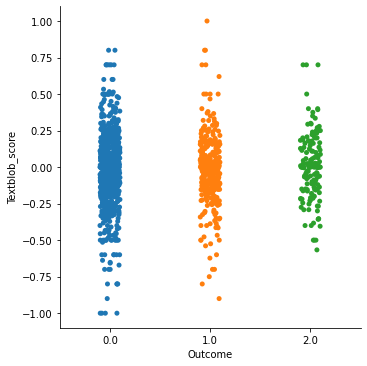

In [37]:
import seaborn as sns

sns.catplot(x="Outcome", y="Textblob_score", data=df_train)
plt.show()

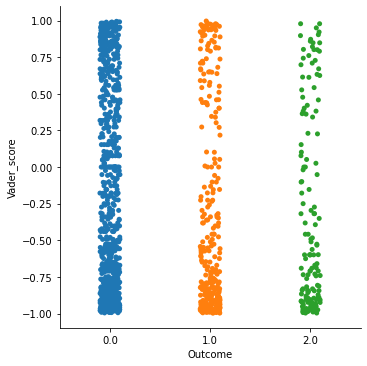

In [38]:
sns.catplot(x="Outcome", y="Vader_score", data=df_train)
plt.show()

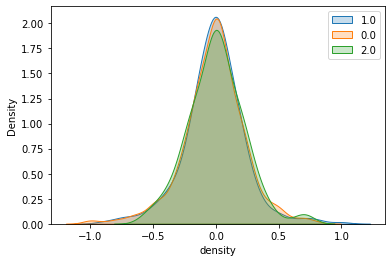

In [39]:
for x in df_train.Outcome.unique():
    sns.distplot(df_train.loc[df_train['Outcome']==x,'Textblob_score'], hist=False, kde=True, kde_kws={'shade':True},label=x, axlabel="density")
plt.legend()

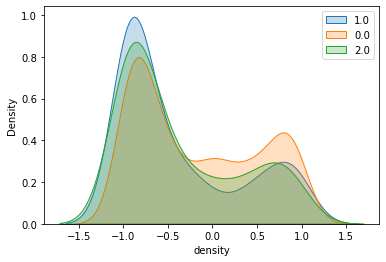

In [40]:
for x in df_train.Outcome.unique():
    sns.distplot(df_train.loc[df_train['Outcome']==x,'Vader_score'], hist=False, kde=True, kde_kws={'shade':True},label=x, axlabel="density")
plt.legend()

### 3.3 TF-IDF Vectors as features

In [42]:
#split the dataset into training and test datasets 
X_train_text = df_train['Text_processed'] 
y_train = df_train['Outcome']
print('Train data shape:',X_train_text.shape, y_train.shape)

X_test_text = df_test['Text_processed'] 
y_test = df_test['Outcome']
print('Test data shape:',X_test_text.shape, y_test.shape)

Train data shape: (1269,) (1269,)
Test data shape: (318,) (318,)


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

tfidf_vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2), min_df=2)
#tfidf_vectorizer = TfidfVectorizer(analyzer='word')
#tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=2)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
print(X_train_tfidf.shape)

(1269, 7557)


In [44]:
#find tf-idf for test
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
print(X_test_tfidf.shape)

(318, 7557)


### 3.4 NER

In [45]:
import spacy
ner = spacy.load("en_core_web_lg")

In [46]:
txt = df_train.loc[1,'Text']
doc = ner(txt)
print(doc)

I’m the guy who puts food in random places in Walmart No reason but I don’t feel like walking back to the other side of the store


In [47]:
spacy.displacy.render(doc, style="ent")

In [48]:
import collections

def utils_lst_count(lst):
    dic_counter = collections.Counter()
    
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict(sorted(dic_counter.items(), key=lambda x:x[1], reverse=True))
    lst_count = [{key:value} for key, value in dic_counter.items()]
    
    return lst_count

In [49]:
#get tags for each ner in train data
df_train['tags'] = df_train['Text'].progress_apply(lambda text:[(tag.text, tag.label_) for tag in ner(text).ents])
#count tags
df_train['tags'] = df_train['tags'].progress_apply(lambda x: utils_lst_count(x))

100%|██████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 248695.06it/s]


In [50]:
df_train.head()

,author,postdate,subreddit,Text,Word_count,Outcome,Text_processed,Textblob_score,Vader_score,tags
0,TFDP117,2020-07-03 03:02:00,suicide watch,My family and friends are the only thing keepi...,25,1.0,family friend thing keeping suicide reason liv...,0.0000,-0.3182,[]
1,jaleel364,2020-02-14 08:28:00,confession,I’m the guy who puts food in random places in ...,27,0.0,guy put food random place walmart reason feel ...,-0.2500,0.3612,"[{('I’m', 'PERSON'): 1}]"
2,mabbers110,2020-03-16 07:47:00,depression,Has anyone here had their life completely turn...,126,0.0,anyone life completely turned around currently...,0.0205,-0.9568,[]
3,AdrianaAura-,2020-08-03 12:44:00,suicide watch,i'm so tired and cold i'm tired\n\nand i just ...,42,1.0,tired cold tired want school life fucking joke...,-0.3417,-0.8994,[]
4,vizzy111,2020-03-24 17:05:00,suicide watch,"They said ma days are numbered, but I keep wak...",23,0.0,said day numbered keep waking think world stil...,-0.5000,-0.3182,"[{('days', 'DATE'): 1}, {('Rip', 'PERSON'): 1}]"


In [51]:
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples)>0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

In [52]:
#extract tag features
tags_set = []
for lst in df_train['tags'].tolist():
    for dic in lst:
        for k in dic.keys():
            tags_set.append(k[1])
            
tags_set = list(set(tags_set))
#view a few tags
print(tags_set[0:5])
print(len(tags_set))

['MONEY', 'WORK_OF_ART', 'FAC', 'DATE', 'EVENT']
18


In [53]:
#OHC each feature
for feature in tags_set:
    df_train['tags_'+feature] = df_train['tags'].progress_apply(lambda x: utils_ner_features(x, feature))

100%|██████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 248706.69it/s]


In [54]:
df_train.head()

,author,postdate,subreddit,Text,Word_count,Outcome,Text_processed,Textblob_score,Vader_score,tags,...,tags_NORP,tags_PRODUCT,tags_LAW,tags_ORDINAL,tags_PERCENT,tags_LANGUAGE,tags_LOC,tags_QUANTITY,tags_PERSON,tags_CARDINAL
0,TFDP117,2020-07-03 03:02:00,suicide watch,My family and friends are the only thing keepi...,25,1.0,family friend thing keeping suicide reason liv...,0.0000,-0.3182,[],...,0,0,0,0,0,0,0,0,0,0
1,jaleel364,2020-02-14 08:28:00,confession,I’m the guy who puts food in random places in ...,27,0.0,guy put food random place walmart reason feel ...,-0.2500,0.3612,"[{('I’m', 'PERSON'): 1}]",...,0,0,0,0,0,0,0,0,1,0
2,mabbers110,2020-03-16 07:47:00,depression,Has anyone here had their life completely turn...,126,0.0,anyone life completely turned around currently...,0.0205,-0.9568,[],...,0,0,0,0,0,0,0,0,0,0
3,AdrianaAura-,2020-08-03 12:44:00,suicide watch,i'm so tired and cold i'm tired\n\nand i just ...,42,1.0,tired cold tired want school life fucking joke...,-0.3417,-0.8994,[],...,0,0,0,0,0,0,0,0,0,0
4,vizzy111,2020-03-24 17:05:00,suicide watch,"They said ma days are numbered, but I keep wak...",23,0.0,said day numbered keep waking think world stil...,-0.5000,-0.3182,"[{('days', 'DATE'): 1}, {('Rip', 'PERSON'): 1}]",...,0,0,0,0,0,0,0,0,1,0


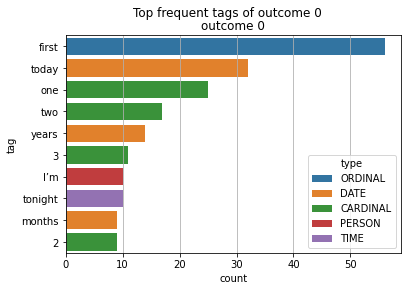

In [55]:
#outcome = 0
tags_list = df_train[df_train['Outcome']==0]['tags'].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type', 'tag']).count().reset_index().sort_values('count', ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags of outcome 0", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
data=dtf_tags.iloc[:10,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.title('outcome 0')
plt.show()


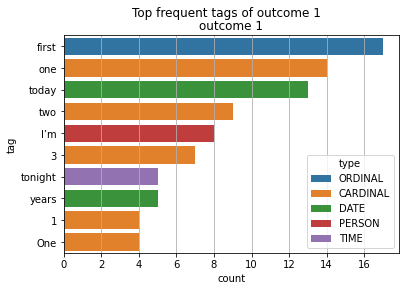

In [56]:
#outcome = 1
tags_list = df_train[df_train['Outcome']==1]['tags'].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type', 'tag']).count().reset_index().sort_values('count', ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags of outcome 1", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
data=dtf_tags.iloc[:10,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.title('outcome 1')
plt.show()


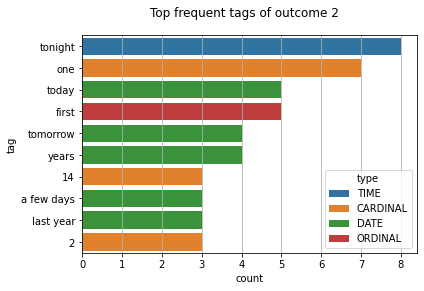

In [57]:
#outcome = 2
tags_list = df_train[df_train['Outcome']==2]['tags'].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type', 'tag']).count().reset_index().sort_values('count', ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags of outcome 2", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
data=dtf_tags.iloc[:10,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()


In [58]:
#get tags for each ner in test data
df_test['tags'] = df_test['Text'].progress_apply(lambda text:[(tag.text, tag.label_) for tag in ner(text).ents])
#count tags
df_test['tags'] = df_test['tags'].progress_apply(lambda x: utils_lst_count(x))

100%|████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 207528.97it/s]


In [59]:
#extract tag features in test data
tags_set_test = []
for lst in df_train['tags'].tolist():
    for dic in lst:
        for k in dic.keys():
            tags_set_test.append(k[1])
            
tags_set_test = list(set(tags_set_test))
#view a few tags
print(tags_set_test[0:5])
print(len(tags_set_test))

['MONEY', 'WORK_OF_ART', 'FAC', 'DATE', 'EVENT']
18


In [60]:
#check if train and test data have same features
tags_set_test == tags_set

True

In [61]:
#OHC each feature in test data
for feature in tags_set:
    df_test['tags_'+feature] = df_test['tags'].progress_apply(lambda x: utils_ner_features(x, feature))

100%|████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 207722.89it/s]


In [62]:
df_test.head()

,author,postdate,subreddit,Text,Word_count,Outcome,Text_processed,Textblob_score,Vader_score,tags,...,tags_NORP,tags_PRODUCT,tags_LAW,tags_ORDINAL,tags_PERCENT,tags_LANGUAGE,tags_LOC,tags_QUANTITY,tags_PERSON,tags_CARDINAL
0,ASOBITAIx4,2020-03-28 03:44:00,confession,My boss said I have a good work ethic when I s...,60,0.0,bos said good work ethic spend half workday pl...,-0.1264,0.6249,"[{('a few work hours', 'TIME'): 1}]",...,0,0,0,0,0,0,0,0,0,0
1,crushedweek,2020-03-27 17:19:00,depression,I feel like I'm not depressed I don't have a r...,134,1.0,feel like depressed real good reason deserve d...,0.0147,-0.9110,"[{('first', 'ORDINAL'): 1}]",...,0,0,0,1,0,0,0,0,0,0
2,tylermufc10,2020-02-27 07:50:00,confession,I used to snort sherbert from the corner shop ...,58,0.0,used snort sherbert corner shop innit understa...,-0.0403,0.4417,"[{('British', 'NORP'): 1}]",...,1,0,0,0,0,0,0,0,0,0
3,BleachtrumpsNaruto,2020-09-02 04:52:00,confession,I caused someone to die because of a seemingly...,201,0.0,caused someone die seemingly meaningless decis...,-0.0965,-0.9001,"[{('Mozambique', 'GPE'): 2}, {('Africa', 'LOC'...",...,0,0,0,0,0,0,1,0,0,0
4,Nillend,2020-03-30 05:44:00,depression,I often wonder why do I even bother Nothing I ...,24,0.0,often wonder even bother nothing ever good eno...,0.2333,-0.5967,[],...,0,0,0,0,0,0,0,0,0,0


In [63]:
#Find all NER vectors
train_ner_vecs = df_train.loc[:,df_train.columns.str.contains('tags_')].to_numpy()
test_ner_vecs = df_test.loc[:,df_train.columns.str.contains('tags_')].to_numpy()

print('Shape of train NER vectors:', len(train_ner_vecs))
print('Shape of test NER vectors:', len(test_ner_vecs))

Shape of train NER vectors: 1269
Shape of test NER vectors: 318


## 4. Model

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### 4.1 Model NB: only TF-IDF

In [65]:
X_train = X_train_tfidf
X_test = X_test_tfidf

print('Shape of train data :',X_train.shape)
print('Shape of train data :',X_test.shape) 

Shape of train data : (1269, 7557)
Shape of train data : (318, 7557)


In [66]:
oversample = SMOTE()
print('Dataset shape:',X_train.shape, y_train.shape )
X, y = oversample.fit_resample(X_train, y_train)
print('Dataset shape after SMOTE:',X.shape, y.shape )

Dataset shape: (1269, 7557) (1269,)
Dataset shape after SMOTE: (2379, 7557) (2379,)


In [71]:
nb = MultinomialNB()
nb.fit(X, y)

MultinomialNB()

In [72]:
#Find accuracy score
print('Test accuracy:',accuracy_score(y_test, nb.predict(X_test)))
print('F1 score:', f1_score(y_test, nb.predict(X_test), average='macro'))

Test accuracy: 0.5094339622641509
F1 score: 0.4757353333614236


In [73]:
#Classification report
print('Test data:\n')
print(classification_report(y_test, nb.predict(X_test)))

Test data:

              precision    recall  f1-score   support

         0.0       0.89      0.42      0.57       199
         1.0       0.37      0.75      0.49        80
         2.0       0.30      0.46      0.36        39

    accuracy                           0.51       318
   macro avg       0.52      0.54      0.48       318
weighted avg       0.69      0.51      0.53       318



In [74]:
#Confusion matrix
confusion_matrix(y_test, nb.predict(X_test), labels=[0,1,2])

array([[84, 83, 32],
       [ 9, 60, 11],
       [ 1, 20, 18]], dtype=int64)

### 4.2 Model SVM : TF-IDF + Vader

In [79]:
train_sentiment_scores = df_train['Vader_score'].to_numpy()
test_sentiment_scores = df_test['Vader_score'].to_numpy()

train_sentiment_scores = np.reshape(train_sentiment_scores,(-1,1))
test_sentiment_scores = np.reshape(test_sentiment_scores,(-1,1))

X_train = hstack([X_train_tfidf, train_sentiment_scores])
print('Shape of train data :',X_train.shape)

X_test = hstack([X_test_tfidf, test_sentiment_scores])
print('Shape of train data :',X_test.shape) 

Shape of train data : (1269, 7558)
Shape of train data : (318, 7558)


In [80]:
oversample = SMOTE()
print('Dataset shape:',X_train.shape, y_train.shape )
X, y = oversample.fit_resample(X_train, y_train)
print('Dataset shape after SMOTE:',X.shape, y.shape )

Dataset shape: (1269, 7558) (1269,)
Dataset shape after SMOTE: (2379, 7558) (2379,)


In [85]:
param_grid = {'C': [0.01, 0.05, 0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],'kernel': ['linear','rbf', 'poly', 'sigmoid'], 'decision_function_shape':['ovo'],'random_state' : [1]}

grid = GridSearchCV(estimator=SVC(),param_grid=param_grid,cv = 5, scoring='accuracy', n_jobs = -1)

grid.fit(X, y)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.937799 using {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear', 'random_state': 1}


In [86]:
#Find accuracy score
print('Test accuracy:',accuracy_score(y_test, grid.predict(X_test)))
print('F1 score:', f1_score(y_test, grid.predict(X_test), average='macro'))

Test accuracy: 0.6823899371069182
F1 score: 0.5435478222490873


In [87]:
#Classification report
print('Test data:\n')
print(classification_report(y_test, grid.predict(X_test)))

Test data:

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       199
         1.0       0.46      0.60      0.52        80
         2.0       0.57      0.21      0.30        39

    accuracy                           0.68       318
   macro avg       0.61      0.54      0.54       318
weighted avg       0.69      0.68      0.67       318



In [88]:
#Confusion matrix
confusion_matrix(y_test, grid.predict(X_test), labels=[0,1,2])

array([[161,  35,   3],
       [ 29,  48,   3],
       [ 10,  21,   8]], dtype=int64)

### 4.3 Model LR:TF-IDF + Vader + Textblob + Topicmodel + NER

In [153]:
#sentiment vectors
train_sentiment_scores = df_train[['Textblob_score', 'Vader_score']].to_numpy()
test_sentiment_scores = df_test[['Textblob_score', 'Vader_score']].to_numpy()

#Find all NER vectors
train_ner_vecs = df_train.loc[:,df_train.columns.str.contains('tags_')].to_numpy()
test_ner_vecs = df_test.loc[:,df_train.columns.str.contains('tags_')].to_numpy()

X_train = hstack([X_train_tfidf, train_topic_vecs, train_sentiment_scores, train_ner_vecs])
print('Shape of train data :',X_train.shape)

X_test = hstack([X_test_tfidf,test_topic_vecs, test_sentiment_scores, test_ner_vecs])
print('Shape of train data :',X_test.shape) 

Shape of train data : (1269, 7592)
Shape of train data : (318, 7592)


In [154]:
oversample = SMOTE()
print('Dataset shape:',X_train.shape, y_train.shape )
X, y = oversample.fit_resample(X_train, y_train)
print('Dataset shape after SMOTE:',X.shape, y.shape )

Dataset shape: (1269, 7592) (1269,)
Dataset shape after SMOTE: (2379, 7592) (2379,)


In [155]:
param_grid = {'C': [0.01, 0.05, 0.1, 1, 10, 100],\
            'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],\
            'random_state' : [1],\
            'n_jobs':[-1]}

grid = GridSearchCV(estimator=LogisticRegression(),param_grid=param_grid,cv = 5, scoring='accuracy', n_jobs = -1)

grid.fit(X, y)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.929389 using {'C': 100, 'n_jobs': -1, 'random_state': 1, 'solver': 'newton-cg'}


In [156]:
#Find accuracy score
print('Test accuracy:',accuracy_score(y_test, grid.predict(X_test)))
print('F1 score:', f1_score(y_test, grid.predict(X_test), average='macro'))

Test accuracy: 0.6949685534591195
F1 score: 0.6026497584541063


In [157]:
#Classification report
print('Test data:\n')
print(classification_report(y_test, grid.predict(X_test)))

Test data:

              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81       199
         1.0       0.48      0.68      0.56        80
         2.0       0.50      0.38      0.43        39

    accuracy                           0.69       318
   macro avg       0.62      0.61      0.60       318
weighted avg       0.72      0.69      0.70       318



In [158]:
#Confusion matrix
confusion_matrix(y_test, grid.predict(X_test), labels=[0,1,2])

array([[152,  38,   9],
       [ 20,  54,   6],
       [  4,  20,  15]], dtype=int64)

## Summary:
Model LR:TF-IDF + Vader + Textblob + Topicmodel + NER with LR is best followed by TD-IDF with NB